## 2D Mult-element airfoil

## Part 1

In [92]:
import os
import numpy as np
from scipy import integrate, linalg
from matplotlib import pyplot as py
%matplotlib inline

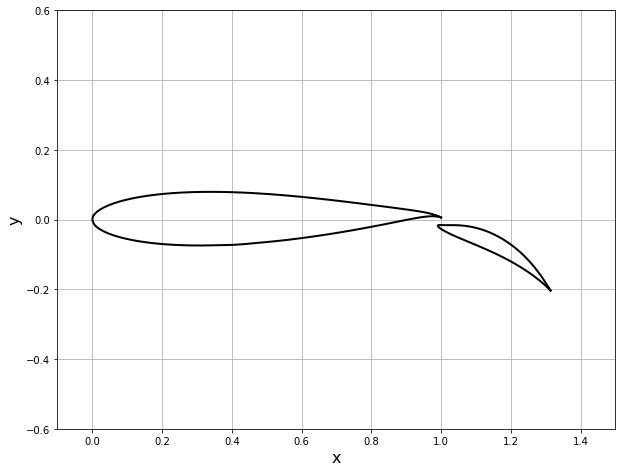

In [93]:
main_foil = os.path.join('MainFoil_N=100.csv')
with open (main_foil, 'r') as file_name:
    x_main, y_main = np.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)
    

flap_foil = os.path.join('FlapFoil_N=100.csv')
with open (flap_foil, 'r') as file_name:
    x_flap, y_flap = np.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

#plot geometry 
width = 10
py.figure(figsize=(width, width))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.plot(x_main, y_main, color='k', linestyle='-', linewidth=2)
py.plot(x_flap, y_flap, color='k', linestyle='-', linewidth=2)
py.axis('scaled', adjustable='box')
py.xlim(-0.1, 1.5)
py.ylim(-0.6, 0.6);

In [94]:
class Panel:
    
    def __init__(self, xa, ya, xb, yb):
       
        self.xa, self.ya = xa, ya  # panel starting-point
        self.xb, self.yb = xb, yb  # panel ending-point
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # panel center
        self.length = np.sqrt((xb - xa)**2 + (yb - ya)**2)  # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = np.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = np.pi + np.arccos(-(yb - ya) / self.length)
        
        # panel location
        if self.beta <= np.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface
        
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient

In [95]:
def define_panels(x, y, N=100):
    
    # create panels
    panels = np.empty(N, dtype=object)
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i + 1], y[i + 1])
    
    return panels

In [96]:
class Freestream:
    
    def __init__(self, u_inf=1.0, alpha=0.0):
        
        self.u_inf = u_inf
        self.alpha = np.radians(alpha)

In [97]:
freestream = Freestream(u_inf=1.0, alpha=4.0)

In [98]:
main_panels = define_panels(x_main, y_main, N=100)
flap_panels = define_panels(x_flap, y_flap, N=100)

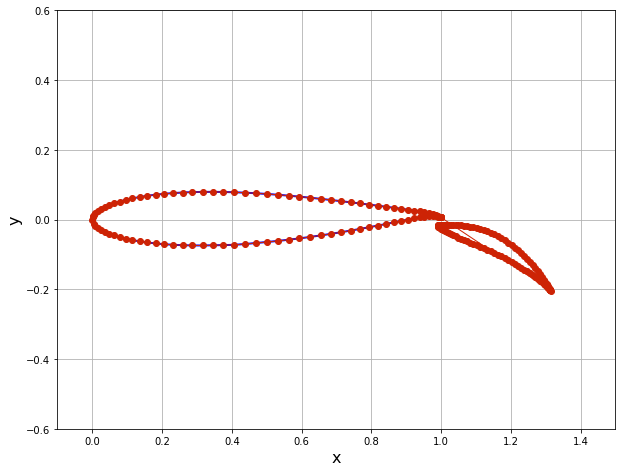

In [99]:
width = 10
py.figure(figsize=(width, width))
py.grid()
py.xlabel('x', fontsize=16)
py.ylabel('y', fontsize=16)
py.plot(x_main, y_main, color='b', linestyle='-', linewidth=2)
py.plot(x_flap, y_flap, color='b', linestyle='-', linewidth=2)
py.plot(np.append([panel.xa for panel in main_panels], main_panels[0].xa),
            np.append([panel.ya for panel in main_panels], main_panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
py.plot(np.append([panel.xa for panel in flap_panels], main_panels[0].xa),
            np.append([panel.ya for panel in flap_panels], main_panels[0].ya),
            linestyle='-', linewidth=1, marker='o', markersize=6, color='#CD2305')
py.axis('scaled', adjustable='box')
py.xlim(-0.1, 1.5)
py.ylim(-0.6, 0.6);

In [100]:
def integral(x, y, panel, dxdk, dydk):
    
    def integrand(s):
        return (((x - (panel.xa - np.sin(panel.beta) * s)) * dxdk +
                 (y - (panel.ya + np.cos(panel.beta) * s)) * dydk) /
                ((x - (panel.xa - np.sin(panel.beta) * s))**2 +
                 (y - (panel.ya + np.cos(panel.beta) * s))**2) )
    return integrate.quad(integrand, 0.0, panel.length)[0]

In [101]:
#source contribution
def source_contribution_normal(panel1, panel2):
    
    A = np.empty((panels.size, panels.size), dtype=float)
    
    # source contribution on a panel from itself
    np.fill_diagonal(A, 0.5)
    
    # source contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = 0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                    panel_j,
                                                    np.cos(panel_i.beta),
                                                    np.sin(panel_i.beta))
    return A

In [102]:
def vortex_contribution_normal(panels):
    
    A = np.empty((panels.size, panels.size), dtype=float)
    # vortex contribution on a panel from itself
    np.fill_diagonal(A, 0.0)
    # vortex contribution on a panel from others
    for i, panel_i in enumerate(panels):
        for j, panel_j in enumerate(panels):
            if i != j:
                A[i, j] = -0.5 / np.pi * integral(panel_i.xc, panel_i.yc, 
                                                     panel_j,
                                                     np.sin(panel_i.beta),
                                                     -np.cos(panel_i.beta))
    return A

In [103]:
main_source = source_contribution_normal(main_panels)
main_vortex = vortex_contribution_normal(main_panels)
flap_source = source_contribution_normal(flap_panels)
flap_vortex = vortex_contribution_normal(flap_panels)

In [104]:
def kutta_condition(A_source, B_vortex):
   
    b = np.empty(A_source.shape[0] + 1, dtype=float)
    
    b[:-1] = B_vortex[0, :] + B_vortex[-1, :]

    b[-1] = - np.sum(A_source[0, :] + A_source[-1, :])
    return b

In [105]:
def build_singularity_matrix(A_source, B_vortex):
    
    A = np.empty((A_source.shape[0] + 1, A_source.shape[1] + 1), dtype=float)

    A[:-1, :-1] = A_source

    A[:-1, -1] = np.sum(B_vortex, axis=1)

    A[-1, :] = kutta_condition(A_source, B_vortex)
    return A

In [106]:
def build_freestream_rhs(panels, freestream):

    b = np.empty(panels.size + 1, dtype=float)

    for i, panel in enumerate(panels):
        b[i] = -freestream.u_inf * np.cos(freestream.alpha - panel.beta)

        b[-1] = -freestream.u_inf * (np.sin(freestream.alpha - panels[0].beta) +
                                 np.sin(freestream.alpha - panels[-1].beta) )
    return b

In [107]:
A_main = build_singularity_matrix(main_source, main_vortex)
b_main = build_freestream_rhs(main_panels, freestream)
A_flap = build_singularity_matrix(flap_source, flap_vortex)
b_flap = build_freestream_rhs(flap_panels, freestream)

In [108]:
strengths_main = np.linalg.solve(A_main, b_main)
strengths_flap = np.linalg.solve(A_flap, b_flap)

#store source strength
for i, panel in enumerate(main_panels):
    panel.sigma = strengths_main[i]
    
for i, panel in enumerate(flap_panels):
    panel.sigma = strengths_flap[i]
    
gamma_main = strengths_main[-1]
gamma_flap = strengths_flap[-1]

In [109]:
def compute_tangential_velocity(panels, freestream, gamma, A_source, B_vortex):
    
    A = np.empty((panels.size, panels.size + 1), dtype=float)
  
    A[:, :-1] = B_vortex
  
    A[:, -1] = -np.sum(A_source, axis=1)

    b = freestream.u_inf * np.sin([freestream.alpha - panel.beta 
                                      for panel in panels])
    
    strengths = np.append([panel.sigma for panel in panels], gamma)
    
    tangential_velocities = np.dot(A, strengths) + b
    
    for i, panel in enumerate(panels):
        panel.vt = tangential_velocities[i]

In [110]:
# tangential velocity at each panel center.
compute_tangential_velocity(main_panels, freestream, gamma_main, main_source, main_vortex)
compute_tangential_velocity(flap_panels, freestream, gamma_flap, main_source, flap_vortex)

In [111]:
def compute_pressure_coefficient(panels, freestream):
    
    for panel in panels:
        panel.cp = 1.0 - (panel.vt / freestream.u_inf)**2

In [112]:
# surface pressure coefficient

compute_pressure_coefficient(main_panels, freestream)
compute_pressure_coefficient(flap_panels, freestream)

In [113]:
main_cp = os.path.join('Cp_Main_theoretical.csv')
with open (main_cp, 'r') as file_name:
    x_main_cp, y_main_cp = np.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)
    

flap_cp = os.path.join('Cp_Flap_theoretical.csv')
with open (flap_cp, 'r') as file_name:
    x_flap_cp, y_flap_cp = np.loadtxt(file_name, dtype=float, delimiter=',', unpack=True)

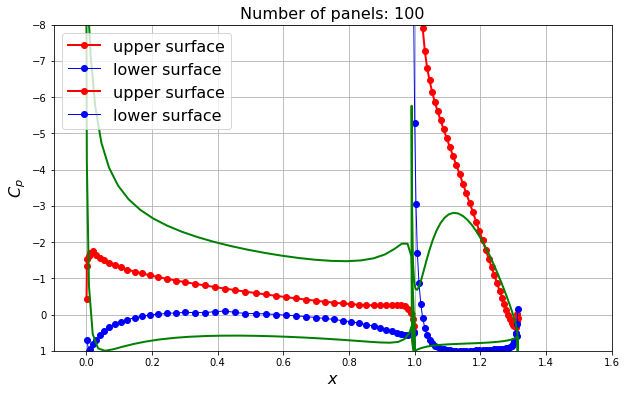

In [114]:
py.figure(figsize=(10, 6))
py.grid()
py.xlabel('$x$', fontsize=16)
py.ylabel('$C_p$', fontsize=16)
py.plot([panel.xc for panel in main_panels if panel.loc == 'upper'],
            [panel.cp for panel in main_panels if panel.loc == 'upper'], label='upper surface', color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
py.plot([panel.xc for panel in main_panels if panel.loc == 'lower'], [panel.cp for panel in main_panels if panel.loc == 'lower'], label= 'lower surface', color='b', linestyle='-', linewidth=1, marker='o', markersize=6)

py.plot([panel.xc for panel in flap_panels if panel.loc == 'upper'],
            [panel.cp for panel in flap_panels if panel.loc == 'upper'], label='upper surface', color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
py.plot([panel.xc for panel in flap_panels if panel.loc == 'lower'], [panel.cp for panel in flap_panels if panel.loc == 'lower'], label= 'lower surface', color='b', linestyle='-', linewidth=1, marker='o', markersize=6)

py.plot(x_main_cp, y_main_cp, color='g', linestyle='-', linewidth=2)
py.plot(x_flap_cp, y_flap_cp, color='g', linestyle='-', linewidth=2)



py.legend(loc='best', prop={'size':16})
py.xlim(-0.1, 1.6)
py.ylim(1.0, -8.0)
py.title('Number of panels: {}'.format(main_panels.size), fontsize=16);

In [117]:
# calculate the accuracy
accuracy1 = sum([panel.sigma * panel.length for panel in main_panels])
print('sum of singularity strengths for main: {:0.6f}'.format(accuracy1))
accuracy2 = sum([panel.sigma * panel.length for panel in flap_panels])
print('sum of singularity strengths for flap: {:0.6f}'.format(accuracy2))

sum of singularity strengths for main: 0.002119
sum of singularity strengths for flap: -0.007228


In [ ]:
# compute the chord and lift coefficient
c = abs(max(panel.xa for panel in main_panels) -
        min(panel.xa for panel in main_panels))
cl = (gamma * sum(panel.length for panel in main_panels) /
      (0.5 * freestream.u_inf * c))
print('lift coefficient: CL = {:0.3f}'.format(cl))